In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Sequential
import tensorflow as tf
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier

path = '/home/dell/Documentos/rn-cin-covid/'
os.chdir(path)


In [39]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

print(tf.config.list_physical_devices("GPU"))

Default GPU Device:/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [40]:
def create_model(dropout_rate=0.0,learn_rate=0.01, momentum=0):
    input_shape = 1024
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(input_shape))
    model.add(tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.05)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units = 256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.05)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = learn_rate, momentum = momentum), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
 
    return model

In [41]:
def evaluate_mlp(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    print("Acurácia teste: ", accuracy_score(y_test, y_pred))
    print("   ")
    
    print(classification_report(y_test, y_pred))
    
    df_cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3g')
    plt.show()

In [42]:
def train_predict_mlp(df_total, test, input_shape):
    
    seed = 97
    np.random.seed(seed)
    
    # Train
    y = df_total[0]
    X = df_total.drop(0, axis=1)

    y = y.to_numpy()
    X = X.to_numpy()
    
    #X = tf.convert_to_tensor(X)
    #y = tf.convert_to_tensor(y)
    
    #Test
    y_test = test[0]
    X_test = test.drop(0, axis=1)

    y_test = y_test.to_numpy()
    X_test = X_test.to_numpy()
    
    #y_test = tf.convert_to_tensor(y_test)
    #X_test = tf.convert_to_tensor(X_test)
    
    model = KerasClassifier(build_fn=create_model, verbose=0)
             
    folds = 10
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 999)
    
    # Grid
    epochs = [10, 25, 50]
    dropout_rate = [0.1, 0.15, 0.2]
    momentum = [0.2,0.5, 0.9]
    learn_rate = [0.0001, 0.001, 0.01]
    batch_size = [32]
    
    
    param_grid = dict(batch_size=batch_size,epochs=epochs, dropout_rate=dropout_rate, learn_rate=learn_rate, momentum=momentum)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = skf, scoring = 'accuracy', verbose=2)
    grid.fit(X,y)

    #print(grid.grid_scores_)
    '''
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    '''

    print ("Best Score: ", grid.best_score_)
    print ("Best params: ", grid.best_params_)
    print("\n")
    
    evaluate_mlp(grid.best_estimator_, X_test, y_test)
    return grid.best_params_ 

In [64]:
def treina_melhor_modelo(df_total,test,best_params,base_name):
    y = df_total[0]
    X = df_total.drop(0, axis=1)

    y = y.to_numpy()
    X = X.to_numpy()

    test_true_x = test.drop(0, axis=1).to_numpy()
    test_true_y = test[0].to_numpy()
    
    knn_results = pd.DataFrame(columns=["base", "acuracia-teste", "precision-covid-teste", "recall-covid-teste", "f1-covid-teste", "precision-non-covid-teste", "recall-non-covid-teste", "f1-non-covid-teste", "conf-matrix-teste", "acuracia-val", "precision-covid-val", "recall-covid-val", "f1-covid-val", "precision-non-covid-val", "recall-non-covid-val", "f1-non-covid-val", "conf-matrix-val"])

    folds = 30

    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 999)
    StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


    acuracia_test = []
    acuracia_val = []
    pre_covid_t = []
    re_covid_t = []
    f1_covid_t = []
    pre_ncovid_t = []
    re_ncovid_t = []
    f1_ncovid_t = []
    pre_covid_v = []
    re_covid_v = []
    f1_covid_v = []
    pre_ncovid_v = []
    re_ncovid_v = []
    f1_ncovid_v = []
    base = []
    conf_matrix_val = []
    conf_matrix_test = []





    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        mlp = create_model(dropout_rate=best_params['dropout_rate'],learn_rate=best_params['learn_rate'], momentum=best_params['momentum'])
   
        history = mlp.fit(X_train, y_train,
                    epochs=best_params["epochs"], verbose=0)
        
        
        y_pred = mlp.predict(X_test)
        predictions = tf.where(y_pred < 0.5, 0, 1)
        y_pred = predictions
        
        y_pred_true = mlp.predict(test_true_x)

        predictions = tf.where(y_pred_true < 0.5, 0, 1)
        y_pred_true = predictions
        

        print( mlp.evaluate(X_test, y_test))
        
        print( mlp.evaluate(test_true_x, test_true_y))
        

        df_cm = confusion_matrix(y_test, y_pred)
        df_cm_test = confusion_matrix(test_true_y, y_pred_true)   
        class_repo = classification_report(y_test, y_pred, output_dict=True)
        class_repo_test = classification_report(test_true_y, y_pred_true, output_dict=True)

        base.append(base_name)
        acuracia_test.append(accuracy_score(test_true_y, y_pred_true))
        acuracia_val.append(accuracy_score(y_test, y_pred))

        pre_covid_t.append(class_repo_test['1']["precision"])
        re_covid_t.append(class_repo_test['1']["recall"])
        f1_covid_t.append(class_repo_test['1']["f1-score"])
        pre_ncovid_t.append(class_repo_test['0']["precision"])
        re_ncovid_t.append(class_repo_test['0']["recall"])
        f1_ncovid_t.append(class_repo_test['0']["f1-score"])

        pre_covid_v.append(class_repo['1']["precision"])
        re_covid_v.append(class_repo['1']["recall"])
        f1_covid_v.append(class_repo['1']["f1-score"])
        pre_ncovid_v.append(class_repo['0']["precision"])
        re_ncovid_v.append(class_repo['0']["recall"])
        f1_ncovid_v.append(class_repo['0']["f1-score"])

        conf_matrix_val.append(df_cm)
        conf_matrix_test.append(df_cm_test)


    knn_results["acuracia-teste"] = acuracia_test
    knn_results["acuracia-val"] = acuracia_val 
    knn_results["precision-covid-teste"] = pre_covid_t 
    knn_results["recall-covid-teste"] = re_covid_t 
    knn_results["f1-covid-teste"] = f1_covid_t 
    knn_results["precision-non-covid-teste"] = pre_ncovid_t
    knn_results["recall-non-covid-teste"] = re_ncovid_t 
    knn_results["f1-non-covid-teste"] = f1_ncovid_t 
    knn_results["precision-covid-val"] = pre_covid_v 
    knn_results["recall-covid-val"] = re_covid_v 
    knn_results["f1-covid-val"] = f1_covid_v 
    knn_results["precision-non-covid-val"] = pre_ncovid_v 
    knn_results["recall-non-covid-val"] = re_ncovid_v 
    knn_results["f1-non-covid-val"] = f1_ncovid_v 
    knn_results["base"] = base 
    knn_results["conf-matrix-val"] = conf_matrix_val
    knn_results["conf-matrix-teste"] = conf_matrix_test 
    
    return(knn_results)

### Densenet Normal


(5394, 1025)
Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.4s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2

[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.5; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.5; total time=   2.3s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, mom

[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.2; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   5.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   4.8s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   4.8s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, mom

[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=   8.8s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=   8.8s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01,

[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   2.4s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   2.2s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   2.1s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, l

[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   5.0s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.5; total time=   4.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.5; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.5; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, l

[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  15.4s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  15.4s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  15.0s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  14.8s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  15.5s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  15.8s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  14.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.001, momentum=0.2; total time=  15.3s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.001, momentum=0.2; total time=  16.2s
[CV] END batch_size=32, dropout_rate=0.15, epoch

[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.5s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.5s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.5s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.9; total time=   3.5s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, le

[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.8s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   4.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, le

[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.8s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.8s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, mom

[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.2; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   8.8s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, mom

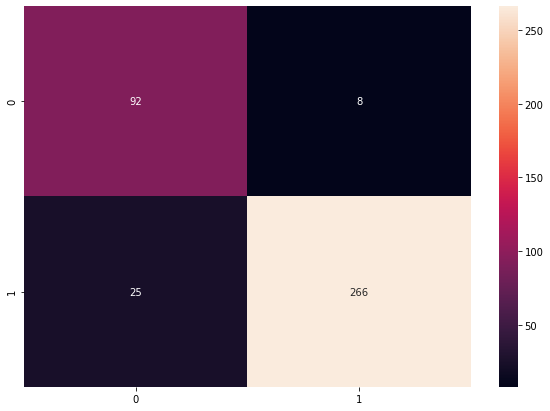

In [44]:
test = pd.read_csv("output/output_densenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)
input_shape = (train.shape[1] -1)

best_params = train_predict_mlp(df_total, test, input_shape)

In [65]:
test = pd.read_csv("output/output_densenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = treina_melhor_modelo(df_total, test, best_params, "densenet")

6/6 [==============================] - 0s 1ms/step - loss: 2.0475 - accuracy: 0.9889
[2.047497034072876, 0.9888888597488403]
13/13 [==============================] - 0s 1ms/step - loss: 2.2708 - accuracy: 0.9130
[2.2708070278167725, 0.9130434989929199]
6/6 [==============================] - 0s 1ms/step - loss: 2.0639 - accuracy: 0.9667
[2.063889741897583, 0.9666666388511658]
13/13 [==============================] - 0s 2ms/step - loss: 2.2835 - accuracy: 0.9003
[2.2834866046905518, 0.9002557396888733]
6/6 [==============================] - 0s 1ms/step - loss: 2.0365 - accuracy: 0.9889
[2.0364949703216553, 0.9888888597488403]
13/13 [==============================] - 0s 1ms/step - loss: 2.2556 - accuracy: 0.9156
[2.2556090354919434, 0.9156010150909424]
6/6 [==============================] - 0s 1ms/step - loss: 2.0891 - accuracy: 0.9778
[2.089052438735962, 0.9777777791023254]
13/13 [==============================] - 0s 1ms/step - loss: 2.2640 - accuracy: 0.9156
[2.263981342315674, 0.915601

### Densenet Augmentation


In [ ]:
test = pd.read_csv("output/output_densenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_mlp(df_total, test, input_shape)


(10788, 1025)
Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   4.6s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   5.8s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   4.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   4.5s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   4.3s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   4.5s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   4.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.2; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.0001, momentum=0.

[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.5; total time=   4.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   4.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   3.8s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.1, epochs=10, learn_rate=0.01, mom

[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.2; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.2; total time=   9.5s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.2; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, momentum=0.5; total time=   8.8s
[CV] END batch_size=32, dropout_rate=0.1, epochs=25, learn_rate=0.01, mom

[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=  17.4s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=  17.7s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.001, momentum=0.9; total time=  17.7s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=  17.6s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=  17.4s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=  17.7s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01, momentum=0.2; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.1, epochs=50, learn_rate=0.01,

[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   3.8s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   4.1s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, learn_rate=0.001, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=10, l

[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   8.8s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.2; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.5; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.5; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, learn_rate=0.001, momentum=0.5; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.15, epochs=25, l

[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  17.6s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  17.1s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  17.8s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.0001, momentum=0.9; total time=  17.7s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.001, momentum=0.2; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.15, epochs=50, learn_rate=0.001, momentum=0.2; total time=  17.4s
[CV] END batch_size=32, dropout_rate=0.15, epoch

[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   4.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.5; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, learn_rate=0.0001, momentum=0.9; total time=   3.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=10, le

[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.2s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.0001, momentum=0.2; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, le

[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   8.9s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.3s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.0s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, momentum=0.9; total time=   9.1s
[CV] END batch_size=32, dropout_rate=0.2, epochs=25, learn_rate=0.01, mom

[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.2; total time=  17.3s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.3s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.8s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.4s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.5s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.7s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, momentum=0.5; total time=  17.8s
[CV] END batch_size=32, dropout_rate=0.2, epochs=50, learn_rate=0.01, mom

In [ ]:
test = pd.read_csv("output/output_densenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "densenet_gauss")])

### MobileNet Normal

In [ ]:
def create_model(dropout_rate=0.0,learn_rate=0.01, momentum=0):
    input_shape = 1280
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(input_shape))
    model.add(tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.05)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units = 256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.05)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = learn_rate, momentum = momentum), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
 
    return model

In [ ]:
test = pd.read_csv("output/output_mobilenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_val_retrained.csv", header=None)

input_shape = (train.shape[1] -1)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_mlp(df_total, test, input_shape)

In [ ]:
test = pd.read_csv("output/output_mobilenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "mobilenet")])

### MobileNet Augmentation

In [ ]:
test = pd.read_csv("output/output_mobilenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_mlp(df_total, test, input_shape)

In [ ]:
test = pd.read_csv("output/output_mobilenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "mobilenet_gauss")])

### VGG16 Normal

In [ ]:
def create_model(dropout_rate=0.0,learn_rate=0.01, momentum=0):
    input_shape = 512
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(input_shape))
    model.add(tf.keras.layers.Dense(units = 512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.05)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units = 256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.05)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = learn_rate, momentum = momentum), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
 
    return model

In [ ]:
test = pd.read_csv("output/output_vgg16_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)
input_shape = (train.shape[1] -1)

best_params = train_predict_mlp(df_total, test, input_shape)

In [ ]:
test = pd.read_csv("output/output_vgg16_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "vgg16")])

### VGG16 Augmentation

In [ ]:
test = pd.read_csv("output/output_vgg16_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_mlp(df_total, test, input_shape)

In [ ]:
test = pd.read_csv("output/output_vgg16_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "vgg16_gauss")])

In [ ]:
results.to_csv("mlp_results.csv")